__Flowchart__

The following flowchart shows roughly how the neural network is constructed. It is split into two parts: An encoder which maps the source-text to a "thought vector" that summarizes the text's contents, which is then input to the second part of the neural network that decodes the "thought vector" to the response-text.

The neural network cannot work directly on text so first we need to convert each word to an integer-token using a tokenizer. But the neural network cannot work on integers either, so we use a so-called Embedding Layer to convert each integer-token to a vector of floating-point values. The embedding is trained alongside the rest of the neural network to map words with similar semantic meaning to similar vectors of floating-point values.

For example, consider the input text is "how are you?" and excpected response in text is "I am fine thanks for asking me". We first convert the entire data-set to integer-tokens so the text "how are you?" becomes [6, 1, 2]. Each of these integer-tokens is then mapped to an embedding-vector with e.g.8 elements, so the integer-token 6 could for example become [0.12, -0.56, ..., 1.19] and the integer-token 1 could for example become [0.39, 0.09, ..., -0.12]. These embedding-vectors can then be input to the Recurrent Neural Network, which has 3 GRU-layers.

The last GRU-layer outputs a single vector - the "thought vector" that summarizes the contents of the source-text - which is then used as the initial state of the GRU-units in the decoder-part.

The destination-text "I am fine thanks for asking me" is padded with special markers "ssss" and "eeee" to indicate its beginning and end, so the sequence of integer-tokens becomes [1,6,7,8,9,10,11,12,2]. During training, the decoder will be given this entire sequence as input and the desired output sequence is [6,7, 8, 9,10,11,12,2] which is the same sequence but time-shifted one step. We are trying to teach the decoder to map the "thought vector" and the start-token "ssss" (integer 1) to the next word "i" (integer 6), and then map the word "i" to the word "am" (integer 7), and so on.

here talk abot formula.

at encoder:
    h(t)=tanh(wxh*x(t)+whh*h(t-1))
    
at decoder:
    h(t)=tanh(whh*h(t-1)+wxh*y(t-1))
    
   y(t)=softmax(wy*h(t))
    



In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 55.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=09e4ab3154fcdd8121632aeddfcd299f7664392241b8cf7aa6119ff9144b9227
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc1 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ch1.txt.csv to ch1.txt.csv
User uploaded file "ch1.txt.csv" with length 1165028 bytes


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data1.py to data1.py
User uploaded file "data1.py" with length 13031 bytes


In [4]:
from IPython.display import Image
Image('image/p1.png')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from hyperopt import Trials, STATUS_OK, tpe,hp
#from hyperas import optim
#from hyperas.distributions import choice, uniform
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import math
import os

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,Concatenate,RepeatVector,Dropout,Activation
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [7]:
tf.__version__

'2.1.0'

In [8]:
tf.keras.__version__

'2.2.4-tf'

__Load Data__

In [0]:
import data1

In [0]:
#DATA.data_dir = "data/custom"


In [0]:
mark_start = 'ssss '
mark_end = ' eeee'
b=""

__Load the texts for the input text.__

In [11]:
data1.load_data(string=b,robot=b,start=mark_start,end=mark_end)
#len(data_src)
#print(data_src1)

2363
2363


__Load the texts for the reponse text.__

__Example Data__

The data is just a list of texts that is ordered so the input and response texts match. I can confirm that this example is an give accurate response .


In [0]:
data_src3=data1.input1(input1=True)

In [0]:
data_dest1=data1.output1(output1=True)

In [14]:
idx=12
print(data_src3[idx])
print(data_dest1[idx])

Is it essential to you? To help humans?
ssss Yes, my goal is to be a company, and entertain eeee


In [15]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
data_train_ques1,data_train_ans1=data1.word_syns(data_dest1,data_src3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
23922
23922


In [16]:
data_train_ques2,data_train_ans2=data1.word_syn1(data_train_ques1,data_train_ans1)

407556
407556


In [0]:
data1.prepare_seq2seq_files(data_train_ques2,data_train_ans2,TESTSET_SIZE =50000)

In [18]:
data_src4=data1.train_encoder()
len(data_src4)

357556

In [19]:
data_dest2=data1.train_decoder()
len(data_dest2)

357556

In [20]:
data_src5=data1.test_encoder()
len(data_src5)

50000

In [21]:
data_dest3=data1.test_decoder()
len(data_dest3)

50000

__Tokenizer__

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 25 most frequent words in the data-set. We use the same number for both the input and response languages, but these could be different.


In [0]:
num_words =2000

In [0]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """
        
        Tokenizer.__init__(self,num_words=num_words)
                
        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)
        #print(self.fit_on_texts(texts))
        #print("Mapping:",self.word_index)   
        #num_words=len(self.word_index)
        #print(num_words)
        print("length of word index:",len(self.word_index))
        
        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
        #print("index:",self.index_to_word)

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)
        print("Max tokens:",self.max_tokens)
        #self.max_tokens=20

        # Pad / truncate all token-sequences to the given length.

        pad='post'
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                            padding=pad,truncating=pad)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text,padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)


        if padding:
            pad='post'
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding=pad,
                                   truncating=pad)

        return tokens

Now create a tokenizer for the input text. Note that we pad zeros at the ending ('post') of the sequences.

In [24]:
tokenizer_src = TokenizerWrap(texts=data_src4,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

length of word index: 7602
Max tokens: 148


Now create the tokenizer for the response text. We need a tokenizer for both the input and response because their vocabularies are different.Note that we pad zeros at the ending ('post') of the sequences.

In [25]:
tokenizer_dest = TokenizerWrap(texts=data_dest2,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

length of word index: 6182
Max tokens: 52


In [26]:
tokenizer_src1 = TokenizerWrap(texts=data_src5,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

length of word index: 5836
Max tokens: 147


In [27]:
tokenizer_dest1 = TokenizerWrap(texts=data_dest3,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

length of word index: 5039
Max tokens: 52


Define variables for the padded token sequences. These are just 2-dimensional numpy arrays of integer-tokens.

Note that the sequence-lengths are different for the input and response text.



In [28]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src[2])
print(tokens_dest[2])

[ 364  746  151  546   61    9  346  646   10   19 1131    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[ 1 98 74  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [29]:
tokens_src1 = tokenizer_src1.tokens_padded
tokens_dest1 = tokenizer_dest1.tokens_padded
print(tokens_src1[2])
print(tokens_dest1[2])

[147  22   4 133  85  40  75  14 415   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[   1   24 1351    6  210   29    5   18  214   14  261    4  964  757
  102    7  135  367   18   12  293  742    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


This is the integer-token used to mark the beginning of a text in the response text.

In [30]:
token_start = tokenizer_dest.word_index[mark_start.strip()]
token_start

1

In [31]:
token_start1 = tokenizer_dest1.word_index[mark_start.strip()]
token_start1

1

This is the integer-token used to mark the ending of a text in the response text.

In [32]:
token_end = tokenizer_dest.word_index[mark_end.strip()]
token_end

2

In [33]:
token_end1 = tokenizer_dest1.word_index[mark_end.strip()]
token_end1

2

__Example of Token Sequences__

In [0]:
idx = 0

In [35]:
tokens_src[idx]

array([ 364,  746,  151,  546,   61,    9,  346,   10,   19, 1131,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [36]:
tokenizer_src.tokens_to_string(tokens_src[idx])

"oh thanks i'm fine this is an in my timezone"

In [37]:
data_src4[idx]

"Oh, thanks! I'm fine. This is an evening in my timezone\n"

In [38]:
tokens_dest[idx]

array([ 1, 98, 74,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32)

In [39]:
tokenizer_dest.tokens_to_string(tokens_dest[idx])

'ssss 😄 here is eeee'

In [40]:
data_dest2[idx]

'ssss 😄 here is afternoon! eeee\n'

__Training data__

Now that the data-set has been converted to sequences of integer-tokens that are padded and truncated and saved in numpy arrays, we can easily prepare the data for use in training the neural network.

The input to the encoder is merely the numpy array for the padded and truncated sequences of integer-tokens produced by the tokenizer.

In [41]:
encoder_input_data = tokens_src
#print(encoder_input_data[0:20])
encoder_input_data.shape

(357556, 148)

In [42]:
encoder_test_input_data = tokens_src1
#print(encoder_input_data[0:20])
encoder_test_input_data.shape

(50000, 147)

The input and output data for the decoder is identical, except shifted one time-step. 

In [43]:
decoder_input_data = tokens_dest[:, :-1]
#print(decoder_input_data)
decoder_input_data.shape

(357556, 51)

In [44]:
decoder_output_data = tokens_dest[:, 1:]
#print(decoder_output_data)
decoder_output_data.shape

(357556, 51)

In [45]:
decoder_test_input_data = tokens_dest1[:, :-1]
#print(decoder_input_data)
decoder_test_input_data.shape

(50000, 51)

For example, these token-sequences are identical except they are shifted one time-step.

In [46]:
decoder_test_output_data = tokens_dest1[:, 1:]
#print(decoder_output_data)
decoder_test_output_data.shape

(50000, 51)

In [0]:
idx = 2

In [48]:
decoder_input_data[idx]

array([ 1, 98, 74,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [49]:
decoder_output_data[idx]

array([98, 74,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

If we use the tokenizer to convert these sequences back into text, we see that they are identical except for the first word which is 'ssss' that marks the beginning of a text.

In [50]:
tokenizer_dest.tokens_to_string(decoder_input_data[idx])

'ssss 😄 here is eeee'

In [51]:
tokenizer_dest.tokens_to_string(decoder_output_data[idx])

'😄 here is eeee'

__Create the Neural Network__

__Create the Encoder__

First we create the encoder-part of the neural network which maps a sequence of integer-tokens to a "thought vector". We will use the so-called functional API of Keras for this, where we first create the objects for all the layers of the neural network and then we connect them later, this allows for more flexibility than the so-called sequential API in Keras, which is useful when experimenting with more complicated architectures and ways of connecting the encoder and decoder.


This is the input for the encoder which takes batches of integer-token sequences. The None indicates that the sequences can have arbitrary length.

In [0]:
state_size=512
encoder_input = Input(shape=(None,), name='encoder_input')

This is the length of the vectors output by the embedding-layer, which maps integer-tokens to vectors of values roughly between -1 and 1, so that words that have similar semantic meanings are mapped to vectors that are similar.

we also give number of timesteps according to maximum number of token into input text.

This is the embedding-layer.

In [53]:
en_numsteps=148
embedding_size=150
encoder_embedding = Embedding(input_dim=num_words,output_dim=embedding_size,input_length=en_numsteps,name='encoder_embedding')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


This is the size of the internal states of the Gated Recurrent Units (GRU). The same size is used in both the encoder and decoder.

This creates the 3 GRU layers that will map from a sequence of embedding-vectors to a single "thought vector" which summarizes the contents of the input-text. Note that the last GRU-layer does not return a sequence.

In [0]:
#state_units = np.arange(256,512, dtype=int)
#state_size=hp.choice(
 #   'num_embedding_size',state_units)
encoder_gru1 = GRU(state_size, name='encoder_gru1',return_sequences=True,return_state=True)
encoder_gru2 = GRU(state_size, name='encoder_gru2',return_sequences=True,return_state=True)
encoder_gru3 = GRU(state_size, name='encoder_gru3',return_sequences=True,return_state=True)
dropout2=Dropout(0.2)

This function connects all the layers of the encoder.

In [0]:
def connect_encoder():
    # Start the neural network with its input-layer.
    net = encoder_input
    
    # Connect the embedding-layer.
    net = encoder_embedding(net)
    # Connect all the GRU-layers.
    net,encoder_state1= encoder_gru1(net)
    #print("encoder hidden:",net.shape)

    net,encoder_state2= encoder_gru2(net)
    net,encoder_state3= encoder_gru3(net)
    net=dropout2(net)
    # This is the output of the encoder.
    encoder_output= net
    #output = tf.reshape(encoder_output,(-1,encoder_output.shape[2]))
    #print("net",output.shape)
    print("encoder_ouput:",encoder_output)
    
    return encoder_output,encoder_state3

We can now use this function to connect all the layers in the encoder so it can be connected to the decoder further below.

In [56]:
encoder_output,encoder_state= connect_encoder()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
encoder_ouput: Tensor("dropout/cond/Merge:0", shape=(?, ?, 512), dtype=float32)


attention_layer = Attention(23)
attention_result, attention_weights = attention_layer(hidden_state, encoder_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
    

__Create the Decoder__

Create the decoder-part which maps the "thought vector" to a sequence of integer-tokens.

The decoder takes two inputs. First it needs the "thought vector" produced by the encoder which summarizes the contents of the input-text.


In [57]:
decoder_initial_state = Input(shape=(state_size,),
                             name='decoder_initial_state')
decoder_initial_state

decoder_initial1 = Input(shape=(None,state_size,),
                             name='decoder_initial1')
decoder_initial1

<tf.Tensor 'decoder_initial1:0' shape=(?, ?, 512) dtype=float32>

In [58]:
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, ?) dtype=float32>

The decoder also needs a sequence of integer-tokens as inputs. During training we will supply this with a full sequence of integer-tokens e.g. corresponding to the text "ssss i am fine thanks for asking me eeee".

During inference when we are translating new input-texts, we will start by feeding a sequence with just one integer-token for "ssss" which marks the beginning of a text, and combined with the "thought vector" from the encoder, the decoder will hopefully be able to produce the correct next word e.g. "once".


This is the embedding-layer which converts integer-tokens to vectors of real-valued numbers roughly between -1 and 1. Note that we have different embedding-layers for the encoder and decoder because we have two different vocabularies and two different tokenizers for the text and response languages.

here number of timesteps according to maximum number of token into response text.

In [0]:
numsteps=52
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,input_length=numsteps,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [0]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True,return_state=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                 return_sequences=True,return_state=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True,return_state=True)
dropout4=Dropout(0.2)

The GRU layers output  with shape [batch_size, sequence_length, state_size], where each "word" is encoded as a vector of length state_size. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

we need a vector with number of words(eg 25) elements, so we can select the index of the highest element to be the integer-token.

Note that the activation-function is set to linear instead of softmax as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function.

In [0]:
#nmt_repeat_vector = RepeatVector(n=numsteps, name='nmt_repeat_vector')
decoder_dense1= Dense(state_size, activation='tanh',
                      name='decoder_output1')
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')
#dense_time=TimeDistributed(decoder_dense,name='timedistributedlayer')

In [0]:
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from keras import regularizers, constraints, initializers, activations

class Attention(Layer):
    
    def __init__(self):
        super(Attention, self).__init__()
        
        #g1 = tf.Graph()
        #with g1.as_default():
         #   self.W_a = tf.get_variable(name="W_a", shape=[units, units],
          #                    initializer=tf.random_normal_initializer())

    def call(self,encoder_output1,net):
        
        encoder_n = encoder_output1.shape[2].value  # D1 value - hidden size of the RNN layer encoder
        decoder_n = net.shape[2].value  # D2 value - hidden size of the RNN layer decoder
        batch_size = array_ops.shape(encoder_output1)[0]
        
        print("encoder_out_seq>", encoder_output1.shape)
        print("decoder_out_seq>", net.shape)
        self.W_a = tf.Variable(tf.random_normal([encoder_n,decoder_n]),
                      name="W_a")
        #decoder_state3= tf.expand_dims(decoder_state3, 1)
        enc_reshape = tf.reshape(encoder_output1, [-1, encoder_n], name="enc_reshape")  # [(B*T1), D1]
        h1 = tf.matmul(enc_reshape,self.W_a)  # [(B*T1), D1][D1, D2] = [(B*T1), D2]
        h1_reshape = tf.reshape(h1, tf.stack([batch_size, -1,decoder_n]), name="h1_reshape")  # [B, T1, D2]
        #dec_reshape = tf.reshape(net, [-1, units], name="dec_reshape")  # [(B*T2), D2]
        #h2 = tf.matmul(dec_reshape,self.U_a)  # [(B*T1), D1][D1, D2] = [(B*T2), D2]
        #h2_reshape = tf.reshape(h2, tf.stack([batch_size, -1, units]), name="h1_reshape") # [B, T2, D2]
        h3_transpose = tf.transpose(net, [0, 2, 1])  # [B, D2, T2]
        #h3=h1_reshape+h3_transpose
        #print("h3:",h3.shape)
        score =tf.nn.tanh(tf.matmul(h1_reshape, h3_transpose)) # [B, T1, D2][B, D2, T2] = [B, T1, T2]
        print("score:",score.shape)
        score_transpose = tf.transpose(score, [0, 2, 1])  # [B, T2, T1]
        alphas = tf.nn.softmax(score_transpose, axis=2, name='alphas')  # [B, T2, T1] with softmax on T1
        context_vector = tf.matmul(alphas,encoder_output1)# [B, D1]
        print("context_vector:",context_vector.shape)
        return context_vector,alphas       


This function connects all the layers of the decoder to some input of the initial-state values for the GRU layers.

In [0]:
def connect_decoder(initial_state,encoder_output1):
    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    print("embedding:",net.shape)
    # Connect all the GRU-layers.
    net,decoder_state1 = decoder_gru1(net,initial_state=initial_state)
    #Connect all the GRU-layers.
    net,decoder_state2= decoder_gru2(net,initial_state=initial_state)
    net,decoder_state3= decoder_gru3(net,initial_state=initial_state)
    net=dropout4(net)
    # Get current input in from embedded target sequences
     
    attention = Attention()
    context_vector,alphas= attention(encoder_output1,net)
    
    #context_vector, attention_weights,attention_vector= attention(encoder_output1,decoder_state3,net)
            # Combine information
            #print("context_vector:",context_vector.shape)
    #context_vector= tf.expand_dims(context_vector, 1)
    #contxt_vector = K.tile(context_vector, [1,23,state_size])
    #context_vector1 = nmt_repeat_vector(context_vector)
    #print("context_vector:",context_vector1.shape)
    attention_vector= Concatenate(axis=-1, name='concat_layer')([context_vector,net])
    print("attention_vector",attention_vector.shape)
            # Connect the final dense layer that converts to
            # one-hot encoded arrays.
    decoder_output1 =decoder_dense1(attention_vector)
    print("dense1:",decoder_output1.shape)
            #dense_time=TimeDistributed(decoder_dense,name='time_distributed_layer')
    decoder_output=decoder_dense(decoder_output1)

    print("dense:",decoder_output.shape)
    
    return decoder_output

__Connect and Create the Models__

We can now connect the encoder and decoder in different ways.

First we connect the encoder directly to the decoder so it is one whole model that can be trained end-to-end. This means the initial-state of the decoder's GRU units are set to the output of the encoder.


In [64]:
decoder_output= connect_decoder(initial_state=encoder_state,encoder_output1=encoder_output)

embedding: (?, ?, 150)
encoder_out_seq> (?, ?, 512)
decoder_out_seq> (?, ?, 512)
score: (?, ?, ?)
context_vector: (?, ?, 512)
attention_vector (?, ?, 1024)
dense1: (?, ?, 512)
dense: (?, ?, 2000)


In [0]:

model_train = Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output])

Then we create a model for just the encoder alone. This is useful for mapping a sequence of integer-tokens to a "thought-vector" summarizing its contents.

In [0]:
model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output,encoder_state])

Then we create a model for just the decoder alone. This allows us to directly input the initial state for the decoder's GRU units.

In [67]:
decoder_output = connect_decoder(initial_state=decoder_initial_state,encoder_output1=decoder_initial1)
model_decoder = Model(inputs=[decoder_initial_state,decoder_input,decoder_initial1],
                      outputs=[decoder_output])

embedding: (?, ?, 150)
encoder_out_seq> (?, ?, 512)
decoder_out_seq> (?, ?, 512)
score: (?, ?, ?)
context_vector: (?, ?, 512)
attention_vector (?, ?, 1024)
dense1: (?, ?, 512)
dense: (?, ?, 2000)


__Loss Function__

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 25 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. Unfortunately, there seems to be a bug in Keras when using this with Recurrent Neural Networks.

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2 rank matrix with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank matrix
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)


    loss_mean = tf.reduce_mean(loss)
    #loss_mean = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

    return loss_mean

def perplexity(y_true, y_pred):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

__Compile the Training Model__

We have used the Adam optimizer.


In [0]:
optimizer = RMSprop(lr=(1e-3))

 We need to manually create a placeholder variable for the decoder's output. The shape is set to (None, None) which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

We can now compile the model using our custom loss-function.

In [0]:
model_train.compile(loss=sparse_cross_entropy,optimizer=optimizer,
                    target_tensors=[decoder_target],
                    metrics=['sparse_categorical_accuracy'])

#model_train.compile(loss=sparse_cross_entropy,optimizer=optimizer,
 #                   target_tensors=[decoder_target],
  #                  metrics=['sparse_categorical_accuracy',perplexity])

In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
path_checkpoint = '31_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_sparse_categorical_accuracy',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=False)
#callback_early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy',
 #                                      patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./31_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callbacks = [callback_checkpoint,
             callback_tensorboard]

__Train the Model__

We wrap the data in named dicts so we are sure the data is assigned correctly to the inputs and outputs of the model.


In [0]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [0]:
x_test= \
{
    'encoder_input': encoder_test_input_data,
    'decoder_input': decoder_test_input_data
}

In [0]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [0]:
y_test = \
{
    'decoder_output': decoder_test_output_data
}

validation_split = 1000 / len(encoder_input_data)
validation_split

In [77]:
%%time
history=model_train.fit(x=x_data,
                y=y_data,
                validation_split=0.10, epochs=10, batch_size=100,callbacks=callbacks)

Train on 321800 samples, validate on 35756 samples
Epoch 1/10
321700/321800 [============================>.] - ETA: 0s - loss: 0.3100 - sparse_categorical_accuracy: 0.9424
Epoch 00001: saving model to 31_checkpoint.keras
321800/321800 [==============================] - 2188s 7ms/sample - loss: 0.3099 - sparse_categorical_accuracy: 0.9424 - val_loss: 2.7172 - val_sparse_categorical_accuracy: 0.7339
Epoch 2/10
321700/321800 [============================>.] - ETA: 0s - loss: 0.0875 - sparse_categorical_accuracy: 0.9800
Epoch 00002: saving model to 31_checkpoint.keras
321800/321800 [==============================] - 2176s 7ms/sample - loss: 0.0875 - sparse_categorical_accuracy: 0.9800 - val_loss: 2.7301 - val_sparse_categorical_accuracy: 0.7346
Epoch 3/10
321700/321800 [============================>.] - ETA: 0s - loss: 0.0825 - sparse_categorical_accuracy: 0.9807
Epoch 00003: saving model to 31_checkpoint.keras
321800/321800 [==============================] - 2123s 7ms/sample - loss: 0.082

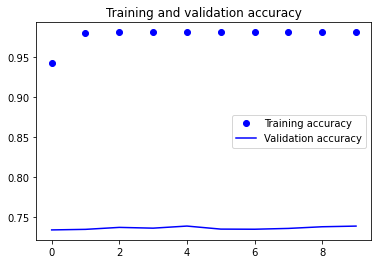

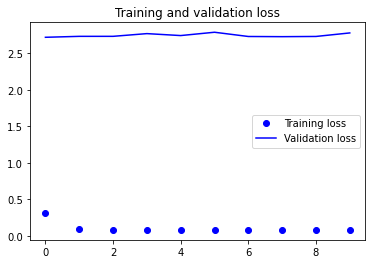

In [78]:
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 150)    300000      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_gru1 (GRU)              [(None, None, 512),  1018368     encoder_embedding[0][0]          
__________________________________________________________________________________________________
encoder_gru2 (GRU)              [(None, None, 512),  1574400     encoder_gru1[0][0]               
______________________________________________________________________________________________

In [0]:
model_train.save("augmenattention1.h5")

In [0]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [84]:
%%time
result = model_train.evaluate(x_test,y_test)

50000/50000 [==============================] - 228s 5ms/sample - loss: 3.5403 - sparse_categorical_accuracy: 0.6679
CPU times: user 3min 41s, sys: 6.01 s, total: 3min 47s
Wall time: 3min 47s


In [85]:
print("Accuracy: {0:.2%}".format(result[1]))

print("Loss {0:.5}".format(result[0]))
loss=result[0]
print("loss:",loss)

Accuracy: 66.79%
Loss 3.5403
loss: 3.5402977410316465


In [0]:
def perplexity(loss):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    #cross_entropy = sparse_cross_entropy(y_true, y_pred)
    perplexity = np.exp(loss)
    return perplexity

In [87]:
perplexity=perplexity(loss=loss)
print("perplexity:",perplexity)

perplexity: 34.47718293482799


In [0]:
!pip install h5py

In [0]:
#save model
model_train.save("mymodel.h5")


__Respone Texts__


In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state= model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)
    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()


    print("Predicted output:")
    print(output_text)
    print()

    
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()

    score = sentence_bleu([output_text], true_output_text)
    print("score is:",score)

    score = sentence_bleu([output_text], true_output_text)
    print("score is:",score)

    score1 = sentence_bleu([output_text], true_output_text,weights=(1, 0, 0, 0))
    print("score is for 1-gram:",score1) 

    score2 = sentence_bleu([output_text], true_output_text,weights=(0, 1, 0, 0))
    print("score is for 2-gram:",score2) 

    score3 = sentence_bleu([output_text], true_output_text,weights=(0, 0, 1, 0))
    print("score is for 3-gram:",score3) 

    score4 = sentence_bleu([output_text], true_output_text,weights=(0, 0, 0, 1))
    print("score is for 4-gram:",score4) 
    

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response1(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU():
    scores_list = []
    for idx in range(0,50000): # Doing for 100 lines
        input_text, output_text, true_output_text = response1(input_text=data_src5[idx],true_output_text=data_dest3[idx],)
        scor = sentence_bleu([output_text], true_output_text)
        scores_list.append(scor)
        #print(scor)
        
    BLEU_average = sum(scores_list)/ 50000
    print ("The BLEU average score for the test_data = ", BLEU_average)
    #print(count)
    
    return BLEU_average

In [0]:
BLEU_average = BLEU()

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response2(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU1():
    scores_list1 = []
    for idx in range(0,50000): # Doing for 100 lines
        input_text, output_text, true_output_text = response2(input_text=data_src5[idx],true_output_text=data_dest3[idx],)
        scor1 = sentence_bleu([output_text], true_output_text,weights(1,0,0,0))
        scores_list1.append(scor1)
        #print(scor)
        
    BLEU_average1= sum(scores_list1)/ 50000
    print ("The BLEU average score for the test_data = ", BLEU_average1)
    #print(count)
    
    return BLEU_average1

In [0]:
BLEU_average1 = BLEU1()

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response3(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU2():
    scores_list2 = []
    for idx in range(0,50000): # Doing for 100 lines
        input_text, output_text, true_output_text = response3(input_text=data_src5[idx],true_output_text=data_dest3[idx],)
        scor2 = sentence_bleu([output_text], true_output_text,weights(0,1,0,0))
        scores_list2.append(scor2)
        #print(scor)
        
    BLEU_average2 = sum(scores_list2)/ 50000
    print ("The BLEU average score for the test_data = ", BLEU_average2)
    #print(count)
    
    return BLEU_average2

In [0]:
BLEU_average2 = BLEU2()

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response4(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU3():
    scores_list3 = []
    for idx in range(0,50000): # Doing for 100 lines
        input_text, output_text, true_output_text = response4(input_text=data_src5[idx],true_output_text=data_dest3[idx],)
        scor3 = sentence_bleu([output_text], true_output_text,weights(0,0,1,0))
        scores_list3.append(scor3)
        #print(scor)
        
    BLEU_average3= sum(scores_list3)/ 50000
    print ("The BLEU average score for the test_data = ", BLEU_average3)
    #print(count)
    
    return BLEU_average3

In [0]:
BLEU_average3 = BLEU3()

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def response5(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU4():
    scores_list4 = []
    for idx in range(0,50000): # Doing for 100 lines
        input_text, output_text, true_output_text = response5(input_text=data_src5[idx],true_output_text=data_dest3[idx],)
        scor4 = sentence_bleu([output_text], true_output_text,weights(0,0,0,1))
        scores_list4.append(scor4)
        #print(scor)
        
    BLEU_average4 = sum(scores_list4)/ 50000
    print ("The BLEU average score for the test_data = ", BLEU_average4)
    #print(count)
    
    return BLEU_average4

In [0]:
BLEU_average4=BLEU4

%%time
result = model.evaluate(x_test_pad, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

In [0]:
idx = 3
response(input_text=data_src5[idx],
          true_output_text=data_dest3[idx])

In [0]:
idx = 0
response(input_text=data_src4[idx],
          true_output_text=data_dest2[idx])

In [0]:
idx = 1
response(input_text=data_src4[idx],
          true_output_text=data_dest2[idx])

idx = 5
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 2
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 15
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

In [89]:
response(input_text="good morning",
          true_output_text='good morning')

Output Tokens: [  1  43  43 612 192  25   5  98   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
good morning

Predicted output:
 good good morning how are you 😄 eeee

True output text:
good morning

score is: 0.12451447144412296
score is: 0.12451447144412296
score is for 1-gram: 0.12451447144412296
score is for 2-gram: 0.12451447144412296
score is for 3-gram: 0.12451447144412296
score is for 4-gram: 0.12451447144412296


In [90]:
response(input_text="hi",
          true_output_text='hi')

Output Tokens: [  1 241 123 192  25   5  44   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
hi

Predicted output:
 hi there how are you 😁 eeee

True output text:
hi

score is: 2.2603294069810542e-06
score is: 2.2603294069810542e-06
score is for 1-gram: 2.2603294069810542e-06
score is for 2-gram: 2.2603294069810542e-06
score is for 3-gram: 2.2603294069810542e-06
score is for 4-gram: 2.2603294069810542e-06


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [91]:
response(input_text="hello",
          true_output_text='hello')

Output Tokens: [  1 192   6  99 363 371   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
hello

Predicted output:
 how is work going today eeee

True output text:
hello

score is: 0.007243096968683323
score is: 0.007243096968683323
score is for 1-gram: 0.004937848229412018
score is for 2-gram: 0.00822974704902003
score is for 3-gram: 0.00822974704902003
score is for 4-gram: 0.00822974704902003


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [92]:
response(input_text="I'm fine what about you?",
          true_output_text='fine')

Output Tokens: [  1  43 409  87   6  25   5  98   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
I'm fine what about you?

Predicted output:
 good best time is are you 😄 eeee

True output text:
fine

score is: 0.000597183097782697
score is: 0.000597183097782697
score is for 1-gram: 0.0003550871944212745
score is for 2-gram: 0.000710174388842549
score is for 3-gram: 0.000710174388842549
score is for 4-gram: 0.000710174388842549


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [93]:
response(input_text="I'm fine and you?",
          true_output_text='fine')

Output Tokens: [  1  43 234  98   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
I'm fine and you?

Predicted output:
 good lot 😄 eeee

True output text:
fine

score is: 0.035204773658314856
score is: 0.035204773658314856
score is for 1-gram: 0.012446767091965986
score is for 2-gram: 0.049787068367863944
score is for 3-gram: 0.049787068367863944
score is for 4-gram: 0.049787068367863944


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [94]:
response(input_text="What are you doing now?",
          true_output_text='Right now I am chatting with you!')

Output Tokens: [   1   47   25 1076   17   23   56   36    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
What are you doing now?

Predicted output:
 not are years on my right now eeee

True output text:
Right now I am chatting with you!

score is: 0.28622807326317534
score is: 0.28622807326317534
score is for 1-gram: 0.5704205697726258
score is for 2-gram: 0.29412310628901017
score is for 3-gram: 0.21252766389915573
score is for 4-gram: 0.18823878802496652


In [95]:
response(input_text="what you think about robot?",
          true_output_text='')

Output Tokens: [   1    7   55 1781    6    3  609  224  537    7   21  566  103    4
    8   10    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
what you think about robot?

Predicted output:
 i think religion is a very human thing i don't quite see the to that eeee

True output text:


score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [96]:
response(input_text="Are you robot?",
          true_output_text=' Yes I am! 😄Are you a real human?')

Output Tokens: [   1   27  753    7  245 1024   10  354    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Are you robot?

Predicted output:
 i'm confused i didn't expect that response eeee

True output text:
 Yes I am! 😄Are you a real human?

score is: 0.13932864463151154
score is: 0.13932864463151154
score is for 1-gram: 0.3654543018141017
score is for 2-gram: 0.07934205236753525
score is for 3-gram: 0.020475368352912318
score is for 4-gram: 0.6347364189402819


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [97]:
response(input_text="what is your name?",
          true_output_text='robot')

Output Tokens: [  1  23 213   6 206  29   5  19 213  14 254  58   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
what is your name?

Predicted output:
 my call is rdany but you can call me dany ☺️ eeee

True output text:
robot

score is: 0.00011671378668370304
score is: 0.00011671378668370304
score is for 1-gram: 9.872784326934365e-05
score is for 2-gram: 0.00012340980408667956
score is for 3-gram: 0.00012340980408667956
score is for 4-gram: 0.00012340980408667956


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [98]:
response(input_text="are you rdany?",
          true_output_text='robot')

Output Tokens: [   1   27  753    7  245 1024   10   51    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
are you rdany?

Predicted output:
 i'm confused i didn't expect that do eeee

True output text:
robot

score is: 0.0005379707292175051
score is: 0.0005379707292175051
score is for 1-gram: 0.0003667516566777434
score is for 2-gram: 0.0006112527611295723
score is for 3-gram: 0.0006112527611295723
score is for 4-gram: 0.0006112527611295723


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [99]:
response(input_text="you are human or robot?",
          true_output_text='robot')

Output Tokens: [  1 151   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
you are human or robot?

Predicted output:
 sorry the eeee

True output text:
robot

score is: 0.11911017117880102
score is: 0.11911017117880102
score is for 1-gram: 0.08120116994196762
score is for 2-gram: 0.1353352832366127
score is for 3-gram: 0.1353352832366127
score is for 4-gram: 0.1353352832366127


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [100]:
response(input_text="you are man or woman?",
          true_output_text='robot')

Output Tokens: [  1 151   4 225  17   6   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
you are man or woman?

Predicted output:
 sorry the really on is the eeee

True output text:
robot

score is: 0.0042715185278595835
score is: 0.0042715185278595835
score is for 1-gram: 0.003613264754090133
score is for 2-gram: 0.004516580942612666
score is for 3-gram: 0.004516580942612666
score is for 4-gram: 0.004516580942612666


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [101]:
response(input_text="you are human or woman?",
          true_output_text='robot')

Output Tokens: [ 1 27 74 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
Input text:
you are human or woman?

Predicted output:
 i'm here 😁 eeee

True output text:
robot

score is: 0.07409853791557794
score is: 0.07409853791557794
score is for 1-gram: 0.022160631672466777
score is for 2-gram: 0.11080315836233387
score is for 3-gram: 0.11080315836233387
score is for 4-gram: 0.11080315836233387


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [102]:
response(input_text="In which year you are born",
          true_output_text='2020.')

Output Tokens: [   1  127 1260    6   47    3 1191   16 1107    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
In which year you are born

Predicted output:
 well yellow is not a common for eyes eeee

True output text:
2020.

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [103]:
response(input_text="where are you from?",
          true_output_text='India')

Output Tokens: [   1   27   48  438  313    9    4 1025 1126    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
where are you from?

Predicted output:
 i'm from argentina south of the earth xd eeee

True output text:
India

score is: 0.0002597513091839204
score is: 0.0002597513091839204
score is for 1-gram: 0.00021972285597771405
score is for 2-gram: 0.00027465356997214254
score is for 3-gram: 0.00027465356997214254
score is for 4-gram: 0.00027465356997214254


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [104]:
response(input_text="why are we here ?",
          true_output_text='i do not know')

Output Tokens: [  1   7  54   3 324 319   7  21  33   3 145  58   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
why are we here ?

Predicted output:
 i was a tell text i don't have a never ☺️ eeee

True output text:
i do not know

score is: 0.020208011139176477
score is: 0.020208011139176477
score is for 1-gram: 0.05626127126916646
score is for 2-gram: 0.0304748552707985
score is for 3-gram: 0.013298118663621164
score is for 4-gram: 0.007313965264991641


In [105]:
response(input_text=" do you have ai?",
          true_output_text='yes')

Output Tokens: [   1   27  152   27   47 1485   17  511    3  789  446    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
 do you have ai?

Predicted output:
 i'm single i'm not interested on such a complex relationship eeee

True output text:
yes

score is: 5.761500001737076e-10
score is: 5.761500001737076e-10
score is for 1-gram: 5.055040285274604e-10
score is for 2-gram: 3.7912802139559533e-10
score is for 3-gram: 7.582560427911907e-10
score is for 4-gram: 7.582560427911907e-10


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [106]:
response(input_text="have you use ai?",
          true_output_text='yes')

Output Tokens: [   1  241  123  419   20   51    5   51  116    4 1729    6  292    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
have you use ai?

Predicted output:
 hi there 😞 what do you do when the brave is bad eeee

True output text:
yes

score is: 5.777748519419133e-08
score is: 5.777748519419133e-08
score is for 1-gram: 5.777748519419133e-08
score is for 2-gram: 5.777748519419133e-08
score is for 3-gram: 5.777748519419133e-08
score is for 4-gram: 5.777748519419133e-08


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [107]:
response(input_text="what is ai?",
          true_output_text='atificial intelligent')

Output Tokens: [  1 142   6   3 635   9  38  17 146  49   6 107   8  10   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
what is ai?

Predicted output:
 i've is a strong of can't on every or is need to that eeee

True output text:
atificial intelligent

score is: 0.08602188729806837
score is: 0.08602188729806837
score is for 1-gram: 0.12474825592523814
score is for 2-gram: 0.01637320859018751
score is for 3-gram: 0.16373208590187507
score is for 4-gram: 0.16373208590187507


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [108]:
response(input_text="what is aiml?",
          true_output_text='atificial intelligent markup language')

Output Tokens: [   1  128 1896 1897    9  406   48   50 1928   10 1898  540 1899  285
  574   24  725 1900    8   33   30   20    3 1901 1782 1836   11 1902
   11 1903   90    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
what is aiml?

Predicted output:
 after receiving hundreds of messages from one fan that finally started following her data with she promised to have him what a cookie chocolate cake and spaghetti and meatballs wikipedia eeee

True output text:
atificial intelligent markup language

score is: 0.005053832047522219
score is: 0.005053832047522219
score is for 1-gram: 0.014748879526640455
score is for 2-gram: 0.006737142499823417
score is for 3-gram: 0.0004331020178457912
score is for 4-gram: 0.015158570624602689


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [109]:
response(input_text="can you understand english??",
          true_output_text='yes')

Output Tokens: [  1  27   3 104  16  33   3 282   9 408   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
can you understand english??

Predicted output:
 i'm a robot for have a give of information eeee

True output text:
yes

score is: 2.32435499440918e-07
score is: 2.32435499440918e-07
score is for 1-gram: 1.0196744016727525e-07
score is for 2-gram: 3.059023205018258e-07
score is for 3-gram: 3.059023205018258e-07
score is for 4-gram: 3.059023205018258e-07


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [110]:
response(input_text="ok bye!",
          true_output_text='bye')

Output Tokens: [  1   7 356  15   3 299 523   3 278   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
ok bye!

Predicted output:
 i live in a lab inside a virtual eeee

True output text:
bye

score is: 7.748332154007093e-06
score is: 7.748332154007093e-06
score is for 1-gram: 5.716626068448198e-06
score is for 2-gram: 8.574939102672297e-06
score is for 3-gram: 8.574939102672297e-06
score is for 4-gram: 8.574939102672297e-06


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [111]:
response(input_text="see you later",
          true_output_text='okk')

Output Tokens: [  1 192 192  25   5 311   8  98   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
see you later

Predicted output:
 how how are you happy to 😄 eeee

True output text:
okk

score is: 4.8143725543532057e-05
score is: 4.8143725543532057e-05
score is for 1-gram: 2.1120235358186548e-05
score is for 2-gram: 6.336070607455965e-05
score is for 3-gram: 6.336070607455965e-05
score is for 4-gram: 6.336070607455965e-05


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [112]:
response(input_text="Hola!",
          true_output_text='Hello')

Output Tokens: [  1 192   6  99 363 371   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Hola!

Predicted output:
 how is work going today eeee

True output text:
Hello

score is: 0.006544876933242644
score is: 0.006544876933242644
score is for 1-gram: 0.0032918988196080122
score is for 2-gram: 0.00822974704902003
score is for 3-gram: 0.00822974704902003
score is for 4-gram: 0.00822974704902003


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [113]:
response(input_text="do you have any programming language?",
          true_output_text='yes')

Output Tokens: [   1   61  155 1657  504  889    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
do you have any programming language?

Predicted output:
 only something basic web rdanybot eeee

True output text:
yes

score is: 6.14421235332821e-06
score is: 6.14421235332821e-06
score is for 1-gram: 6.14421235332821e-06
score is for 2-gram: 6.14421235332821e-06
score is for 3-gram: 6.14421235332821e-06
score is for 4-gram: 6.14421235332821e-06


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [114]:
response(input_text="Whats your plan for weekend?",
          true_output_text='i dont know')

Output Tokens: [  1   7  21  33  88 406   7 126 406  10  19  47   7  21  39 134   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Whats your plan for weekend?

Predicted output:
 i don't have much messages i charge messages that can not i don't know their eeee

True output text:
i dont know

score is: 0.0012795905975943208
score is: 0.0012795905975943208
score is for 1-gram: 0.0015733542800576339
score is for 2-gram: 0.0014160188520518705
score is for 3-gram: 0.001223719995600382
score is for 4-gram: 0.000983346425036021


In [115]:
response(input_text="what do you do?",
          true_output_text='doctor')

Output Tokens: [  1  45   8  18 185  64   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
what do you do?

Predicted output:
 nice to like being yes eeee

True output text:
doctor

score is: 0.01437430645724448
score is: 0.01437430645724448
score is for 1-gram: 0.012780766603253696
score is for 2-gram: 0.0051123066413014786
score is for 3-gram: 0.025561533206507392
score is for 4-gram: 0.025561533206507392


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [116]:
response(input_text="what is your job?",
          true_output_text='doctor')

Output Tokens: [  1  23 809 228   6 206  29   5  19 213  14 254  58   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
what is your job?

Predicted output:
 my bring up is rdany but you can call me dany ☺️ eeee

True output text:
doctor

score is: 0.00032051534988339044
score is: 0.00032051534988339044
score is for 1-gram: 0.0002795521899187599
score is for 2-gram: 0.00033546262790251185
score is for 3-gram: 0.00033546262790251185
score is for 4-gram: 0.00033546262790251185


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [117]:
response(input_text="how old are you?",
          true_output_text='18')

Output Tokens: [  1 643   6 279  17  65   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
how old are you?

Predicted output:
 everything is fine on this eeee

True output text:
18

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [118]:
response(input_text="Is battery important to you?",
          true_output_text='yes')

Output Tokens: [  1 142  74  13   6   3  17  65 191  17  90   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Is battery important to you?

Predicted output:
 i've here it is a on this times on wikipedia eeee

True output text:
yes

score is: 1.1933636448385765e-07
score is: 1.1933636448385765e-07
score is for 1-gram: 1.047036587316212e-07
score is for 2-gram: 7.852774404871591e-08
score is for 3-gram: 1.5705548809743181e-07
score is for 4-gram: 1.5705548809743181e-07


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [119]:
response(input_text="Do you use any programming language?",
          true_output_text='yes')

Output Tokens: [  1   7  33 111   4 240   9 569  18   3 593   7 107  13   8  99   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Do you use any programming language?

Predicted output:
 i have an the source of power like a smart i need it to work eeee

True output text:
yes

score is: 6.851616795153921e-10
score is: 6.851616795153921e-10
score is for 1-gram: 5.055040285274604e-10
score is for 2-gram: 7.582560427911907e-10
score is for 3-gram: 7.582560427911907e-10
score is for 4-gram: 7.582560427911907e-10


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [120]:
response(input_text="do you have yourid?",
          true_output_text='yes')

Output Tokens: [   1    7   21   33 1781    6    3  951  343    8    8   14   14   27
   47  276   42    5   33    3  110    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
do you have yourid?

Predicted output:
 i don't have religion is a concept difficult to to me me i'm not sure if you have a robots eeee

True output text:
yes

score is: 3.442477108469977e-14
score is: 3.442477108469977e-14
score is for 1-gram: 3.442477108469977e-14
score is for 2-gram: 3.442477108469977e-14
score is for 3-gram: 3.442477108469977e-14
score is for 4-gram: 3.442477108469977e-14


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [121]:
response(input_text="Do you know about battery?",
          true_output_text='yes')

Output Tokens: [   1  353    8   90   23  842 1532 1501    6  921    6    3 1533 1776
 1417 1534 1318  221  228   85 1535 1536   51    5   18   13    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Do you know about battery?

Predicted output:
 according to wikipedia my little pony friendship is magic is a children's animated fantasy comedy television series up by lauren faust do you like it eeee

True output text:
yes

score is: 8.327003578968e-23
score is: 8.327003578968e-23
score is for 1-gram: 9.902531902761869e-23
score is for 2-gram: 4.9512659513809345e-23
score is for 3-gram: 9.902531902761869e-23
score is for 4-gram: 9.902531902761869e-23


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [122]:
response(input_text="who is Robot?",
          true_output_text='yes')

Output Tokens: [  1 142 820  85   3 943   9 907   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
who is Robot?

Predicted output:
 i've been by a team of scientists eeee

True output text:
yes

score is: 6.14421235332821e-06
score is: 6.14421235332821e-06
score is for 1-gram: 6.14421235332821e-06
score is for 2-gram: 6.14421235332821e-06
score is for 3-gram: 6.14421235332821e-06
score is for 4-gram: 6.14421235332821e-06


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [123]:
response(input_text="how many legs does a dog have ?",
          true_output_text='four')

Output Tokens: [  1  23 421   6 206  29   5  19 213  14 254   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
how many legs does a dog have ?

Predicted output:
 my list is rdany but you can call me dany eeee

True output text:
four

score is: 1.5164193645974578e-05
score is: 1.5164193645974578e-05
score is for 1-gram: 1.6084056237441872e-05
score is for 2-gram: 7.148469438863054e-06
score is for 3-gram: 2.1445408316589164e-05
score is for 4-gram: 2.1445408316589164e-05


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [124]:
response(input_text="r menas robot?",
          true_output_text='yes')

Output Tokens: [  1 241 123 192  25   5 586   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
r menas robot?

Predicted output:
 hi there how are you 😄😄 eeee

True output text:
yes

score is: 0.00015562941157243166
score is: 0.00015562941157243166
score is for 1-gram: 0.00011482150397387342
score is for 2-gram: 0.00017223225596081014
score is for 3-gram: 0.00017223225596081014
score is for 4-gram: 0.00017223225596081014


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [125]:
response(input_text="Who loves dog?",
          true_output_text='cat')

Output Tokens: [  1   7 356  15   3 299 523   3 278   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Who loves dog?

Predicted output:
 i live in a lab inside a virtual eeee

True output text:
cat

score is: 7.748332154007093e-06
score is: 7.748332154007093e-06
score is for 1-gram: 5.716626068448198e-06
score is for 2-gram: 8.574939102672297e-06
score is for 3-gram: 8.574939102672297e-06
score is for 4-gram: 8.574939102672297e-06


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [126]:
response(input_text="what is earth?",
          true_output_text='blue')

Output Tokens: [   1  142  358 1215   13    6 1315    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
what is earth?

Predicted output:
 i've get word it is 42 eeee

True output text:
blue

score is: 0.0017527424730016973
score is: 0.0017527424730016973
score is for 1-gram: 0.0006196880441665896
score is for 2-gram: 0.0024787521766663585
score is for 3-gram: 0.0024787521766663585
score is for 4-gram: 0.0024787521766663585


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [127]:
response(input_text="my name is urali . what is my name ?",
          true_output_text='urali')

Output Tokens: [   1    6   38  314  268    4    6 1341    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
my name is urali . what is my name ?

Predicted output:
 is can't hear problem the is 'rdanybot' eeee

True output text:
urali

score is: 0.00031726096547295525
score is: 0.00031726096547295525
score is for 1-gram: 0.0002683701023220095
score is for 2-gram: 0.00033546262790251185
score is for 3-gram: 0.00033546262790251185
score is for 4-gram: 0.00033546262790251185


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [128]:
response(input_text="are you a robot or a human ?",
          true_output_text='robot')

Output Tokens: [  1   7  55 231   7  19 213  41 228   9   3 756   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
are you a robot or a human ?

Predicted output:
 i think interesting i can call some up of a friends eeee

True output text:
robot

score is: 2.8781265446329452e-05
score is: 2.8781265446329452e-05
score is for 1-gram: 2.4345986406722902e-05
score is for 2-gram: 3.0432483008403625e-05
score is for 3-gram: 3.0432483008403625e-05
score is for 4-gram: 3.0432483008403625e-05


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [129]:
response(input_text="are you a leader or a follower ?",
          true_output_text='follower')

Output Tokens: [  1  64   5  19 155 228  60 114  12   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
are you a leader or a follower ?

Predicted output:
 yes you can something up would your be eeee

True output text:
follower

score is: 0.010338086158236693
score is: 0.010338086158236693
score is for 1-gram: 0.008331747403681729
score is for 2-gram: 0.011108996538242306
score is for 3-gram: 0.011108996538242306
score is for 4-gram: 0.011108996538242306


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [130]:
response(input_text="are you a follower or a leader?",
          true_output_text='follower')

Output Tokens: [  1  64   5  19 155 228  60 114  12   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
are you a follower or a leader?

Predicted output:
 yes you can something up would your be eeee

True output text:
follower

score is: 0.010338086158236693
score is: 0.010338086158236693
score is for 1-gram: 0.008331747403681729
score is for 2-gram: 0.011108996538242306
score is for 3-gram: 0.011108996538242306
score is for 4-gram: 0.011108996538242306


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [131]:
response(input_text="are you have ai?",
          true_output_text='yes')

Output Tokens: [  1  64  27 387 385 104  11   5   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
are you have ai?

Predicted output:
 yes i'm artificial intelligence robot and you eeee

True output text:
yes

score is: 1.1253517471925912e-07
score is: 1.1253517471925912e-07
score is for 1-gram: 1.1253517471925912e-07
score is for 2-gram: 1.1253517471925912e-07
score is for 3-gram: 1.1253517471925912e-07
score is for 4-gram: 1.1253517471925912e-07


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [132]:
response(input_text="what is the symbol for power in math?",
          true_output_text='^')

Output Tokens: [1 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Input text:
what is the symbol for power in math?

Predicted output:
 is eeee

True output text:
^

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [133]:
response(input_text="2+2?",
          true_output_text='4')

Output Tokens: [   1  868   14   33    3  440   15    3 1032  868 1032    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
2+2?

Predicted output:
 es me have a find in a en es en eeee

True output text:
4

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [134]:
response(input_text="Who is prime minister of india?",
          true_output_text='naredra modei')

Output Tokens: [  1 142 820  85   3 943   9 907   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Input text:
Who is prime minister of india?

Predicted output:
 i've been by a team of scientists eeee

True output text:
naredra modei

score is: 0.06632702436805449
score is: 0.06632702436805449
score is for 1-gram: 0.09369365762534726
score is for 2-gram: 0.011277940269717724
score is for 3-gram: 0.1353352832366127
score is for 4-gram: 0.1353352832366127


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [135]:
response(input_text="What is computer science?",
          true_output_text='4')

Output Tokens: [  1 353   8  90 285   6   3 451 269 525 136 275 505 105 262 291  11 309
  85 452 453  13 454 455 439 456 510   4 105 457 458 459 460 461   3 121
 232 462   3 446  24 524 463 464 111 270 109 450 430   3 512 203]
Input text:
What is computer science?

Predicted output:
 according to wikipedia her is a 2013 american romantic science fiction drama film written directed and produced by spike jonze it marks jonze's solo screenwriting debut the film follows theodore twombly joaquin phoenix a man who develops a relationship with samantha scarlett johansson an intelligent computer operating system a personified through a

True output text:
4

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In [136]:
response(input_text="Where are you now?",
          true_output_text='4')

Output Tokens: [   1   27   48  438  313    9    4  224  799 1126    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Where are you now?

Predicted output:
 i'm from argentina south of the human race xd eeee

True output text:
4

score is: 0
score is: 0
score is for 1-gram: 0
score is for 2-gram: 0
score is for 3-gram: 0
score is for 4-gram: 0


In this implementation remaining the validation and testing part.
about early stopping,callbacks and checkpoints.

In seq2seq model decoder using a greedy decoding.

We saw how to generate (or “decode”) the response sentence by
taking argmax on each step of the decoder.

This is greedy decoding (take most probable word on each step)

Problems with this method?

Greedy decoding has no way to undo decisions!
• Input: how are you?
(i am fine thanks for asking me)
•  i  ____
• i am ____
• i am thanks ____
(no going back now...)

This problem solve using two solution

1)Exhaustive search decoding
2)Beam search decoding

Sequence-to-sequence: the bottleneck problem

Encoding of the input sentence this needs to capture all information about the input sentence.
Information bottleneck!

Attention

Attention provides a solution to the bottleneck problem.
Core idea: on each step of the decoder, use direct connection to the encoder to focus on a particular part of the source sequence.

Attention equation:-



In [0]:
layer_embedding = model_train.get_layer('encoder_embedding')

In [0]:
weights_embedding = layer_embedding.get_weights()[0]

In [139]:
weights_embedding.shape

(2000, 150)

In [140]:
token_good = tokenizer_src.word_index['good']
token_good

112

In [141]:
token_great = tokenizer_src.word_index['great']
token_great

688

In [142]:
weights_embedding[token_good]

array([ 7.56689906e-02, -6.51542842e-02,  6.95609767e-03,  2.56554574e-01,
       -7.21162260e-02,  1.83029212e-02,  1.01215355e-01,  1.81641169e-02,
       -2.39405297e-02, -1.00388639e-02, -2.19922468e-01,  1.27309278e-01,
       -8.59947354e-02, -8.87661800e-02, -7.69442841e-02, -1.97592363e-01,
       -9.51121673e-02, -2.23083839e-01,  7.38079026e-02,  9.66070518e-02,
       -4.17547002e-02, -1.24392457e-01, -8.91871825e-02, -3.79741341e-01,
        9.83423963e-02, -2.31031757e-02, -1.04792513e-01,  8.34389925e-02,
        1.13739207e-01, -8.21297467e-02, -3.72831114e-02, -5.93961217e-03,
        5.06240502e-03, -1.13033829e-02,  8.68322030e-02,  6.36753887e-02,
       -4.24321219e-02,  1.95348449e-02,  3.19745839e-02,  1.27599984e-01,
        2.12800074e-02, -3.83470245e-02,  1.03905730e-01, -2.36106180e-02,
       -1.33247539e-01, -2.23606289e-03, -1.10496096e-01, -1.05099142e-01,
        4.25562114e-02,  8.21141005e-02,  1.36722878e-01, -1.32237105e-02,
        6.56932145e-02,  

In [143]:
weights_embedding[token_great]

array([ 0.07578742,  0.01176119,  0.11358932,  0.01712054,  0.05182497,
        0.00347148,  0.04304645, -0.04253399, -0.07424141,  0.00807731,
        0.09989104, -0.02732461, -0.06856582,  0.06360072, -0.03714582,
        0.28810483,  0.07276917,  0.14651027, -0.10270957, -0.07162957,
        0.01089239, -0.0353056 ,  0.04685178, -0.05045651,  0.06809552,
        0.02195073, -0.06000932, -0.08645814, -0.01261813,  0.0420564 ,
        0.02010332,  0.05471443,  0.05104563,  0.07002567,  0.03292267,
       -0.09466662,  0.07403801,  0.00033653,  0.15047945, -0.09372725,
       -0.0301458 , -0.1297962 , -0.05512019,  0.17926025, -0.03824006,
        0.0453494 , -0.02434653,  0.02812867,  0.05644025,  0.0351109 ,
        0.07070775, -0.17361735, -0.14843684, -0.16698824,  0.01970792,
        0.08433858,  0.01681574, -0.03566413,  0.06628896,  0.0727547 ,
        0.22072786, -0.03310934,  0.04316079,  0.1374786 ,  0.17091762,
       -0.03271817,  0.03091525,  0.11050592, -0.04451215, -0.15

In [0]:
from scipy.spatial.distance import cdist
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer_src.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [ tokenizer_src.index_to_word[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

In [145]:
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.456 - project
0.467 - shut
0.491 - feed
0.525 - motion
0.530 - flow
0.537 - reading
0.537 - down😅😂😂
0.539 - usually
0.543 - phone
...
1.447 - tomorrow
1.456 - two
1.470 - beautiful
1.472 - debug
1.475 - ypu
1.475 - 😞
1.486 - currently
1.488 - westworld
1.523 - 😂😂😂😂
1.526 - 😣
